In [1]:
import warnings
import pandas as pd
import numpy as np
from pyqstrat.pq_utils import *
from pyqstrat.plot import *

,gmean,amean,std,shrp,srt,calmar,mar,mdd_pct,mdd_dates,dd_3y_pct,dd_3y_timestamps,up_dwn,2018
,0.0635,0.000166,0.000899,2.93,5.69,-8.73,-8.73,-0.00479,2018-01-19/2018-01-22,-0.00479,2018-01-19/2018-01-22,34/25/0.576,0.0635


<Figure size 432x288 with 0 Axes>

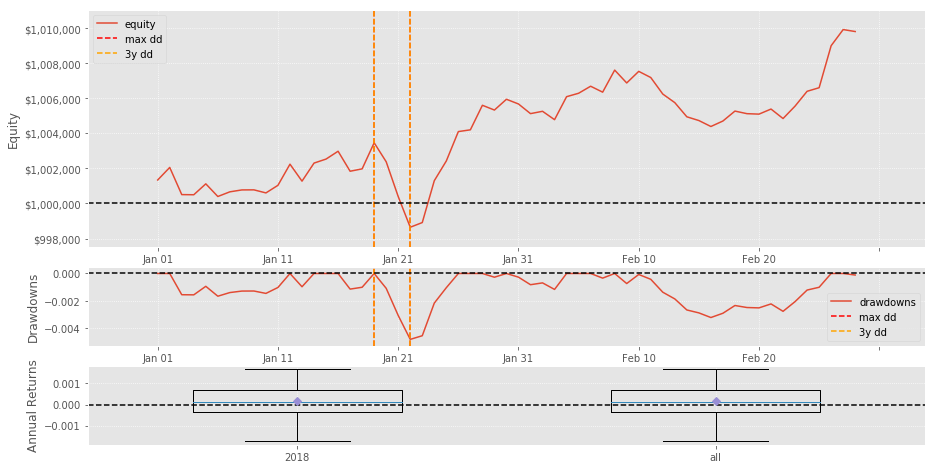

In [2]:
_VERBOSE = False

def compute_amean(returns):
    """Computes arithmetic mean of a return array, ignoring NaNs
    
    Args:
        returns: a numpy array of floats representing returns at any frequency
        
    Returns:
        a float
        
    >>> compute_amean(np.array([3, 4, np.nan]))
    3.5
    """
    if not len(returns): return np.nan
    return np.nanmean(returns)

def compute_periods_per_year(timestamps):
    """Computes trading periods per year for an array of numpy datetime64's.
      E.g. if most of the timestamps are separated by 1 day, will return 252.
      
    Args:
        timestamps: a numpy array of datetime64's
        
    Returns:
        a float
        
    >>> compute_periods_per_year(np.array(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-09'], dtype = 'M8[D]'))
    252.0
    >>> round(compute_periods_per_year(np.array(['2018-01-01 10:00', '2018-01-01 10:05', '2018-01-01 10:10'], dtype = 'M8[m]')), 2)
    72576.05
    """
    if not len(timestamps): return np.nan
    freq = infer_frequency(timestamps)
    return 252. / freq if freq != 0 else np.nan

def compute_num_periods(timestamps, periods_per_year):
    """ Given an array of timestamps, we compute how many periods there are between the first and last element, where the length
        of a period is defined by periods_per_year.  For example, if there are 6 periods per year, then each period would be approx. 2 months long.
        
    Args:
        timestamps (np.ndarray of np.datetime64): a numpy array of returns, can contain nans
        periods_per_year (int): number of periods between first and last return
        
    Returns:
        a float
        
    >>> compute_num_periods(np.array(['2015-01-01', '2015-03-01', '2015-05-01'], dtype = 'M8[D]'), 6)
    2.0
    """
    if not len(timestamps): return np.nan
    assert(monotonically_increasing(timestamps))
    fraction_of_year = (timestamps[-1] - timestamps[0]) / (np.timedelta64(1, 's') * 365 * 24 * 60 * 60)
    return round(fraction_of_year * periods_per_year)
    

def compute_gmean(timestamps, returns, periods_per_year):
    """ Computes geometric mean of an array of returns
    
    Args:
        returns: a numpy array of returns, can contain nans
        periods_per_year: Used for annualizing returns
    Returns:
        a float
        
    >>> round(compute_gmean(np.array(['2015-01-01', '2015-03-01', '2015-05-01'], dtype = 'M8[D]'), np.array([0.001, 0.002, 0.003]), 252.), 6)
    0.018362
    """
    if not len(returns): return np.nan
    assert(len(returns) == len(timestamps))
    assert(isinstance(timestamps, np.ndarray) and isinstance(returns, np.ndarray))
    returns = returns[np.isfinite(returns)]
    num_periods = compute_num_periods(timestamps, periods_per_year)
    g_mean = ((1.0 + returns).prod())**(1.0/num_periods)
    g_mean = np.power(g_mean, periods_per_year) - 1.0
    return g_mean

def compute_std(returns):
    """ Computes standard deviation of an array of returns, ignoring nans """
    if not len(returns): return np.nan
    return np.nanstd(returns)

def compute_sortino(returns, amean, periods_per_year):
    '''
    Note that this assumes target return is 0.
    
    Args:
        returns: a numpy array of returns
        amean: arithmetic mean of returns
        periods_per_year: number of trading periods per year
        
    >>> print(round(compute_sortino(np.array([0.001, -0.001, 0.002]), 0.001, 252), 6))
    33.674916
    '''
    if not len(returns) or not np.isfinite(amean) or periods_per_year <= 0: return np.nan
    returns = np.where((~np.isfinite(returns)), 0.0, returns)
    normalized_rets = np.where(returns > 0.0, 0.0, returns)
    sortino_denom = np.std(normalized_rets)
    sortino = np.nan if sortino_denom == 0 else amean / sortino_denom * np.sqrt(periods_per_year)
    return sortino

def compute_sharpe(returns, amean, periods_per_year):
    '''
    Note that this does not take into risk free returns so it's really a sharpe0, i.e. assumes risk free returns are 0
    
    Args:
        returns: a numpy array of returns
        amean: arithmetic mean of returns
        periods_per_year: number of trading periods per year
        
    >>> round(compute_sharpe(np.array([0.001, -0.001, 0.002]), 0.001, 252), 6)
    12.727922
    '''
    if not len(returns) or not np.isfinite(amean) or periods_per_year <= 0: return np.nan
    returns = np.where((~np.isfinite(returns)), 0.0, returns)
    s = np.std(returns)
    sharpe = np.nan if s == 0 else amean / s * np.sqrt(periods_per_year)
    return sharpe

def compute_equity(timestamps, starting_equity, returns):
    ''' Given starting equity, timestamps and returns, create a numpy array of equity at each date'''
    return starting_equity * np.cumprod(1. + returns)

def compute_rolling_dd(timestamps, equity):
    '''
    Compute numpy array of rolling drawdown percentage
    
    Args:
        timestamps: numpy array of datetime64
        equity: numpy array of equity
    '''
    assert(len(timestamps) == len(equity))
    if not len(timestamps): return np.array([], dtype = 'M8[ns]'), np.array([], dtype = np.float)
    s = pd.Series(equity, index = timestamps)
    rolling_max = s.expanding(min_periods = 1).max()
    dd = np.where(s >= rolling_max, 0.0, (s - rolling_max) / rolling_max)
    return timestamps, dd

def compute_maxdd_pct(rolling_dd):
    '''Compute max drawdown percentage given a numpy array of rolling drawdowns, ignoring NaNs'''
    if not len(rolling_dd): return np.nan
    return np.nanmin(rolling_dd)

def compute_maxdd_date(rolling_dd_dates, rolling_dd):
    ''' Compute date of max drawdown given numpy array of timestamps, and corresponding rolling dd percentages'''
    if not len(rolling_dd_dates): return pd.NaT
    assert(len(rolling_dd_dates) == len(rolling_dd))
    return rolling_dd_dates[np.argmin(rolling_dd)]

def compute_maxdd_start(rolling_dd_dates, rolling_dd, mdd_date):
    '''Compute date when max drawdown starts, given numpy array of timestamps corresponding rolling dd 
        percentages and date that max dd starts'''
    if not len(rolling_dd_dates) or pd.isnull(mdd_date): return pd.NaT
    assert(len(rolling_dd_dates) == len(rolling_dd))
    return rolling_dd_dates[(rolling_dd >= 0) & (rolling_dd_dates < mdd_date)][-1]

def compute_mar(returns, periods_per_year, mdd_pct):
    '''Compute MAR ratio, which is annualized return divided by biggest drawdown since inception.'''
    if not len(returns) or np.isnan(mdd_pct) or mdd_pct == 0: return np.nan
    return np.mean(returns) * periods_per_year / mdd_pct

def compute_dates_3yr(timestamps):
    ''' Given an array of numpy datetimes, return those that are within 3 years of the last date in the array'''
    if not len(timestamps): return np.array([], dtype = 'M8[D]')
    last_date = timestamps[-1]
    d = pd.to_datetime(last_date)
    start_3yr = np.datetime64( d.replace(year = d.year - 3))
    return timestamps[timestamps > start_3yr]

def compute_returns_3yr(timestamps, returns):
    '''Given an array of numpy datetimes and an array of returns, return those that are within 3 years 
        of the last date in the datetime array '''
    if not len(timestamps): return np.array([], dtype = np.float)
    assert(len(timestamps) == len(returns))
    timestamps_3yr = compute_dates_3yr(timestamps)
    return returns[timestamps >= timestamps_3yr[0]]

def compute_rolling_dd_3yr(timestamps, equity):
    '''Compute rolling drawdowns over the last 3 years'''
    if not len(timestamps): return np.array([], dtype = 'M8[D]')
    last_date = timestamps[-1]
    d = pd.to_datetime(last_date)
    start_3yr = np.datetime64( d.replace(year = d.year - 3))
    equity = equity[timestamps >= start_3yr]
    timestamps = timestamps[timestamps >= start_3yr]
    return compute_rolling_dd(timestamps, equity)

def compute_maxdd_pct_3yr(rolling_dd_3yr):
    '''Compute max drawdown percentage over the last 3 years'''
    return compute_maxdd_pct(rolling_dd_3yr)

def compute_maxdd_date_3yr(rolling_dd_3yr_timestamps, rolling_dd_3yr):
    '''Compute max drawdown date over the last 3 years'''
    return compute_maxdd_date(rolling_dd_3yr_timestamps, rolling_dd_3yr)

def compute_maxdd_start_3yr(rolling_dd_3yr_timestamps, rolling_dd_3yr, mdd_date_3yr):
    '''Comput max drawdown start date over the last 3 years'''
    return compute_maxdd_start(rolling_dd_3yr_timestamps, rolling_dd_3yr, mdd_date_3yr)

def compute_calmar(returns_3yr, periods_per_year, mdd_pct_3yr):
    '''Compute Calmar ratio, which is the annualized return divided by max drawdown over the last 3 years'''
    return compute_mar(returns_3yr, periods_per_year, mdd_pct_3yr)

def compute_bucketed_returns(timestamps, returns):
    '''
    Bucket returns by year
    
    Returns:
        A tuple with the first element being a list of years and the second a list of 
            numpy arrays containing returns for each corresponding year
    '''
    assert(len(timestamps) == len(returns))
    if not len(timestamps): return np.array([], dtype = np.str), np.array([], dtype = np.float)
    s = pd.Series(returns, index = timestamps)
    years_list = []
    rets_list = []
    for year, rets in s.groupby(s.index.map(lambda x : x.year)):
        years_list.append(year)
        rets_list.append(rets.values)
    
    return years_list, rets_list

def compute_annual_returns(timestamps, returns, periods_per_year):
    '''Takes the output of compute_bucketed_returns and returns geometric mean of returns by year
    
    Returns:
        A tuple with the first element being an array of years (integer) and the second element 
        an array of annualized returns for those years
        
    '''
    assert(len(timestamps) == len(returns) and periods_per_year > 0)
    if not len(timestamps): return np.array([], dtype = np.str), np.array([], dtype = np.float)
    df = pd.DataFrame({'ret' : returns, 'timestamp' : timestamps})
    years = []
    gmeans = []
    for k, g in df.groupby(df.timestamp.map(lambda x: x.year)):
        years.append(k)
        gmeans.append(compute_gmean(g.timestamp.values, g.ret.values, periods_per_year))
    return np.array(years), np.array(gmeans)

class Evaluator:
    """You add functions to the evaluator that are dependent on the outputs of other functions.  
    The evaluator will call these functions in the right order
    so dependencies are computed first before the functions that need their output.  
    You can retrieve the output of a metric using the metric member function
    
    >>> evaluator = Evaluator(initial_metrics={'x' : np.array([1, 2, 3]), 'y' : np.array([3, 4, 5])})
    >>> evaluator.add_metric('z', lambda x, y: sum(x, y), dependencies=['x', 'y'])
    >>> evaluator.compute()
    >>> evaluator.metric('z')
    array([ 9, 10, 11])
    """
    def __init__(self, initial_metrics):
        """Inits Evaluator with a dictionary of initial metrics that are used to compute subsequent metrics
        
        Args:
            initial_metrics: a dictionary of string name -> metric.  metric can be any object including a scalar, 
                an array or a tuple
        """
        assert(type(initial_metrics) == dict)
        self.metric_values = initial_metrics
        self._metrics = {}
        
    def add_metric(self, name, func, dependencies):
        self._metrics[name] = (func, dependencies)
    
    def compute(self, metric_names = None):
        '''Compute metrics using the internal dependency graph
        
        Args:
            metric_names: an array of metric names.  If not passed in, evaluator will compute and store all metrics
        '''

        if metric_names is None: metric_names = list(self._metrics.keys())
        for metric_name in metric_names:
            if _VERBOSE: print(f'computing: {metric_name}')
            self.compute_metric(metric_name)
            
    def compute_metric(self, metric_name):
        '''
        Compute and store a single metric:
        
        Args:
            metric_name: string representing the metric to compute
        '''
        func, dependencies = self._metrics[metric_name]
        for dependency in dependencies:
            if dependency not in self.metric_values:
                self.compute_metric(dependency)
        dependency_values = {k: self.metric_values[k] for k in dependencies}
        
        values = func(**dependency_values)
            
        self.metric_values[metric_name] = values
                
    def metric(self, metric_name):
        '''Return the value of a single metric given its name'''
        return self.metric_values[metric_name]
    
    def metrics(self):
        '''Return a dictionary of metric name -> metric value'''
        return self.metric_values
    
def handle_non_finite_returns(timestamps, rets, leading_non_finite_to_zeros, subsequent_non_finite_to_zeros): 
    '''
    >>> np.set_printoptions(formatter={'float': '{: .6g}'.format})
    >>> timestamps = np.arange(np.datetime64('2019-01-01'), np.datetime64('2019-01-07'))
    >>> rets = np.array([np.nan, np.nan, 3, 4, np.nan, 5])
    >>> handle_non_finite_returns(timestamps, rets, leading_non_finite_to_zeros = False, subsequent_non_finite_to_zeros = True)
    (array(['2019-01-03', '2019-01-04', '2019-01-05', '2019-01-06'], dtype='datetime64[D]'), array([ 3,  4,  0,  5]))
    >>> handle_non_finite_returns(timestamps, rets, leading_non_finite_to_zeros = True, subsequent_non_finite_to_zeros = False)
    (array(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04', '2019-01-06'], dtype='datetime64[D]'), array([ 0,  0,  3,  4,  5]))
    >>> handle_non_finite_returns(timestamps, rets, leading_non_finite_to_zeros = False, subsequent_non_finite_to_zeros = False)
    (array(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04', '2019-01-06'], dtype='datetime64[D]'), array([ 0,  0,  3,  4,  5]))
    >>> rets = np.array([1, 2, 3, 4, 4.5,  5])
    >>> handle_non_finite_returns(timestamps, rets, leading_non_finite_to_zeros = False, subsequent_non_finite_to_zeros = True)
    (array(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04', '2019-01-05', '2019-01-06'], 
        dtype='datetime64[D]'), array([ 1,  2,  3,  4,  4.5,  5]))
    '''
    
    first_non_nan_index = np.ravel(np.nonzero(~np.isnan(rets)))
    if len(first_non_nan_index):
        first_non_nan_index = first_non_nan_index[0]
    else:
        first_non_nan_index = -1
    
    if first_non_nan_index > 0 and first_non_nan_index < len(rets):
        if leading_non_finite_to_zeros:
            rets[:first_non_nan_index] = np.nan_to_num(rets[:first_non_nan_index])
        else:
            timestamps = timestamps[first_non_nan_index:]
            rets = rets[first_non_nan_index:]
    
    if subsequent_non_finite_to_zeros:
        rets = np.nan_to_num(rets)
    else:
        timestamps = timestamps[np.isfinite(rets)]
        rets = rets[np.isfinite(rets)]
    
    return timestamps, rets
    
def compute_return_metrics(timestamps, rets, starting_equity, leading_non_finite_to_zeros = False, subsequent_non_finite_to_zeros = True):
    '''
    Compute a set of common metrics using returns (for example, of an instrument or a portfolio)
    
    Args:
        timestamps (np.array of datetime64): Timestamps for the returns
        rets (nd.array of float): The returns, use 0.01 for 1%
        starting_equity (float): Starting equity value in your portfolio
        leading_non_finite_to_zeros (bool, optional): If set, we replace leading nan, inf, -inf returns with zeros.  
            For example, you may need a warmup period for moving averages.  Default False
        subsequent_non_finite_to_zeros (bool, optional): If set, we replace any nans that follow the first non nan value with zeros.
            There may be periods where you have no prices but removing these returns would result in incorrect annualization. 
            Default True
         
    Returns:
        An Evaluator object containing computed metrics off the returns passed in.  
        If needed, you can add your own metrics to this object based on the values of existing metrics and recompute the Evaluator.
        Otherwise, you can just use the output of the evaluator using the metrics function.
        
    >>> timestamps = np.array(['2015-01-01', '2015-03-01', '2015-05-01', '2015-09-01'], dtype = 'M8[D]')
    >>> rets = np.array([0.01, 0.02, np.nan, -0.015])
    >>> starting_equity = 1.e6
    >>> ev = compute_return_metrics(timestamps, rets, starting_equity)
    >>> metrics = ev.metrics()
    >>> assert(round(metrics['gmean'], 6) == 0.021061)
    >>> assert(round(metrics['sharpe'], 6) == 0.599382)
    >>> assert(all(metrics['returns_3yr'] == np.array([0.01, 0.02, 0, -0.015])))
    '''
    
    assert(starting_equity > 0.)
    assert(type(rets) == np.ndarray and rets.dtype == np.float64)
    assert(type(timestamps) == np.ndarray and np.issubdtype(timestamps.dtype, np.datetime64) and monotonically_increasing(timestamps))
    
    #rets = np.nan_to_num(rets)
    
    timestamps, rets = handle_non_finite_returns(timestamps, rets, leading_non_finite_to_zeros, subsequent_non_finite_to_zeros)

    ev = Evaluator({'timestamps' : timestamps, 'returns' : rets, 'starting_equity' : starting_equity})
    ev.add_metric('periods_per_year', compute_periods_per_year, dependencies = ['timestamps'])
    ev.add_metric('amean', compute_amean, dependencies = ['returns'])
    ev.add_metric('std', compute_std, dependencies = ['returns'])
    ev.add_metric('up_periods', lambda returns : len(returns[returns > 0]), dependencies = ['returns'])
    ev.add_metric('down_periods', lambda returns : len(returns[returns < 0]), dependencies = ['returns'])
    ev.add_metric('up_pct', 
                  lambda up_periods, down_periods : up_periods * 1.0 / (up_periods + down_periods) if (up_periods + down_periods) != 0 else np.nan, 
                  dependencies=['up_periods', 'down_periods'])
    ev.add_metric('gmean', compute_gmean, dependencies=['timestamps', 'returns', 'periods_per_year'])
    ev.add_metric('sharpe', compute_sharpe, dependencies = ['returns', 'periods_per_year', 'amean'])
    ev.add_metric('sortino', compute_sortino, dependencies = ['returns', 'periods_per_year', 'amean'])
    ev.add_metric('equity', compute_equity, dependencies = ['timestamps', 'starting_equity', 'returns'])
    
    # Drawdowns
    ev.add_metric('rolling_dd', compute_rolling_dd, dependencies = ['timestamps', 'equity'])
    ev.add_metric('mdd_pct', lambda rolling_dd : compute_maxdd_pct(rolling_dd[1]), dependencies = ['rolling_dd'])
    ev.add_metric('mdd_date', lambda rolling_dd : compute_maxdd_date(rolling_dd[0], rolling_dd[1]), dependencies = ['rolling_dd'])
    ev.add_metric('mdd_start', lambda rolling_dd, mdd_date : compute_maxdd_start(rolling_dd[0], rolling_dd[1], mdd_date), 
                  dependencies = ['rolling_dd', 'mdd_date'])
    ev.add_metric('mar', compute_mar, dependencies = ['returns', 'periods_per_year', 'mdd_pct'])
    
    ev.add_metric('timestamps_3yr', compute_dates_3yr, dependencies = ['timestamps'])
    ev.add_metric('returns_3yr', compute_returns_3yr, dependencies = ['timestamps', 'returns'])

    ev.add_metric('rolling_dd_3yr', compute_rolling_dd_3yr, dependencies = ['timestamps', 'equity'])
    ev.add_metric('mdd_pct_3yr', lambda rolling_dd_3yr : compute_maxdd_pct_3yr(rolling_dd_3yr[1]), dependencies = ['rolling_dd_3yr'])
    ev.add_metric('mdd_date_3yr', lambda rolling_dd_3yr : compute_maxdd_date_3yr(rolling_dd_3yr[0], rolling_dd_3yr[1]) , 
                  dependencies = ['rolling_dd_3yr'])
    ev.add_metric('mdd_start_3yr', lambda rolling_dd_3yr, mdd_date_3yr : 
                  compute_maxdd_start_3yr(rolling_dd_3yr[0], rolling_dd_3yr[1], mdd_date_3yr), 
                  dependencies = ['rolling_dd_3yr', 'mdd_date_3yr'])
    ev.add_metric('calmar', compute_calmar, dependencies = ['returns_3yr', 'periods_per_year', 'mdd_pct_3yr'])

    ev.add_metric('annual_returns', compute_annual_returns, dependencies=['timestamps', 'returns', 'periods_per_year'])
    ev.add_metric('bucketed_returns', compute_bucketed_returns, dependencies=['timestamps', 'returns'])

    ev.compute()
    return ev

def display_return_metrics(metrics, float_precision = 3):
    '''
    Creates a dataframe making it convenient to view the output of the metrics obtained using the compute_return_metrics function.
    
    Args:
        float_precision: Change if you want to display floats with more or less significant figures than the default, 
            3 significant figures.       
    Returns:
        A one row dataframe with formatted metrics.
    '''
    from IPython.core.display import display
    
    _metrics = {}
    cols = ['gmean', 'amean', 'std', 'shrp', 'srt', 'calmar', 'mar', 'mdd_pct', 'mdd_start', 'mdd_date', 'dd_3y_pct', 'up_periods', 'down_periods', 'up_pct',
           'mdd_start_3yr', 'mdd_date_3yr']
    
    translate = {'shrp' : 'sharpe', 'srt' : 'sortino', 'dd_3y_pct' : 'mdd_pct_3yr'}
    for col in cols:
        key = col
        if col in translate: key = translate[col]
        _metrics[col] = metrics[key]
            
    _metrics['mdd_dates'] = f'{str(metrics["mdd_start"])[:10]}/{str(metrics["mdd_date"])[:10]}'
    _metrics['up_dwn'] = f'{metrics["up_periods"]}/{metrics["down_periods"]}/{metrics["up_pct"]:.3g}'
    _metrics['dd_3y_timestamps'] = f'{str(metrics["mdd_start_3yr"])[:10]}/{str(metrics["mdd_date_3yr"])[:10]}'
    
    years = metrics['annual_returns'][0]
    ann_rets = metrics['annual_returns'][1]
    for i, year in enumerate(years):
        _metrics[str(year)] = ann_rets[i]
        
    format_str = '{:.' + str(float_precision) + 'g}'
        
    for k, v in _metrics.items():
        if isinstance(v, np.float) or isinstance(v, float):
            _metrics[k] = format_str.format(v)
       
    cols = ['gmean', 'amean', 'std', 'shrp', 'srt', 'calmar', 'mar', 'mdd_pct', 'mdd_dates', 'dd_3y_pct', 'dd_3y_timestamps', 'up_dwn'
           ] + [str(year) for year in sorted(years)]
    
    df = pd.DataFrame(index = [''])
    for metric_name, metric_value in _metrics.items():
        df.insert(0, metric_name, metric_value)
    df = df[cols]
        
    display(df)
    return df

def plot_return_metrics(metrics, title = None):
    '''
    Plot equity, rolling drawdowns and and a boxplot of annual returns given the output of compute_return_metrics.
    '''
    returns = metrics['returns']
    timestamps = metrics['timestamps']
    equity =  metrics['equity']
    equity = TimeSeries('equity', timestamps = timestamps, values = equity)
    mdd_date, mdd_start = metrics['mdd_start'], metrics['mdd_date']
    mdd_date_3yr, mdd_start_3yr = metrics['mdd_start_3yr'], metrics['mdd_date_3yr']
    drawdown_lines = [DateLine(name = 'max dd', date = mdd_start, color = 'red'),
                      DateLine(date = mdd_date, color = 'red'),
                      DateLine(name = '3y dd', date = mdd_start_3yr, color = 'orange'),
                      DateLine(date = mdd_date_3yr, color = 'orange')]
    equity_subplot = Subplot(equity, ylabel = 'Equity', height_ratio = 0.6, log_y = True, y_tick_format = '${x:,.0f}', 
                             date_lines = drawdown_lines, horizontal_lines=[HorizontalLine(metrics['starting_equity'], color = 'black')]) 
    

    rolling_dd = TimeSeries('drawdowns', timestamps = metrics['rolling_dd'][0], values = metrics['rolling_dd'][1])
    zero_line = HorizontalLine(y = 0, color = 'black')
    dd_subplot = Subplot(rolling_dd, ylabel = 'Drawdowns', height_ratio = 0.2, date_lines = drawdown_lines, horizontal_lines = [zero_line])
    
    years = metrics['bucketed_returns'][0]
    ann_rets = metrics['bucketed_returns'][1]
    ann_ret = BucketedValues('annual returns', bucket_names = years, bucket_values = ann_rets)
    ann_ret_subplot = Subplot(ann_ret, ylabel = 'Annual Returns', height_ratio = 0.2, horizontal_lines=[zero_line])
    
    
    plt = Plot([equity_subplot, dd_subplot, ann_ret_subplot], title = title)
    plt.draw()
 
#if __name__ == "__main__":
def test_evaluator():
    from datetime import datetime, timedelta
    np.random.seed(10)
    timestamps = np.arange(datetime(2018, 1, 1), datetime(2018, 3, 1), timedelta(days = 1))
    rets = np.random.normal(size = len(timestamps)) / 1000
    starting_equity = 1.e6
    
    ev = compute_return_metrics(timestamps, rets, starting_equity)
    metrics = display_return_metrics(ev.metrics());
    plot_return_metrics(ev.metrics())
    
    assert(round(ev.metric('sharpe'), 6) == 2.932954)
    assert(round(ev.metric('sortino'), 6) == 5.690878)
    assert(ev.metric('annual_returns')[0] == [2018])
    assert(round(ev.metric('annual_returns')[1][0], 6) == [0.063530])
    assert(ev.metric('mdd_start') == np.datetime64('2018-01-19'))
    assert(ev.metric('mdd_date') == np.datetime64('2018-01-22'))
    
if __name__ == "__main__":
    test_evaluator()
    import doctest
    doctest.testmod(optionflags = doctest.NORMALIZE_WHITESPACE)
